# 畳み込みニューラルネットワーク（CNN）チュートリアル

このノートブックでは、畳み込みニューラルネットワーク（CNN）について詳細なハンズオン形式で説明します。CNNは画像のようなグリッド状のデータを処理するために特別に設計された強力なディープラーニングアーキテクチャです。標準的な画像デセットを使用して、CNNモデルの構築、トレーニング、評価を行います。

# 本セクションのポイント

- 畳み込み層による局所的パターン抽出

フィルタ（カーネル）をスライドさせることで、画像中のエッジやテクスチャなどの空間的特徴を捉えます。

- プーリング層での次元削減と不変性

Max Poolingなどで特徴マップのサイズを縮小し、計算量を抑えつつ、平行移動などへの頑健性を高めます。

- 多層構造と転移学習

畳み込み層とプーリング層を重ね、最後に全結合層で分類を行う構造を採用。事前学習モデルを微調整する転移学習も広く使われます。 

## CNNの基礎: なぜ画像処理に最適なのか？

### 従来のニューラルネットワークの限界

通常のニューラルネットワーク（全結合型）では、入力画像のピクセルをすべて個別の入力として扱います。例えば32x32のカラー画像（3チャネル）では、入力ニューロン数が32x32x3=3072個にもなります。これには以下の問題があります：

1. **パラメータ数の爆発**: 各ニューロン間の接続が多すぎて計算効率が悪い
2. **空間構造の無視**: 画像の2次元的な空間構造を考慮していない
3. **位置変化に弱い**: 同じ物体が画像内で少し移動しただけで全く異なる入力として認識される

### CNNの優位性

CNNはこれらの問題を以下のような特徴で解決します：

1. **局所的受容野（Local Receptive Field）**: 各ニューロンは画像の小さな領域だけを見る
2. **パラメータ共有（Parameter Sharing）**: 同じフィルターを画像全体に適用するので、パラメータ数を大幅に削減
3. **平行移動不変性（Translation Invariance）**: 同じ特徴が画像内のどこにあっても検出できる

これにより、CNNは画像から階層的に特徴を抽出できるようになり、画像認識タスクで非常に高い性能を発揮します。

## 必要なライブラリのインポート

In [ ]:
!pip install japanize-matplotlib

# TensorFlow、Keras、NumPy、Matplotlibなど必要なライブラリをインポート
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# 再現性のためにランダムシードを設定
np.random.seed(42)
tf.random.set_seed(42)

# ライブラリのバージョンを表示
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"NumPy version: {np.__version__}")

## データセットの読み込みと前処理

このチュートリアルでは、CIFAR-10データセットを使用します。このデータセットは10クラスの32x32カラー画像60,000枚から構成されており、50,000枚の訓練画像と10,000枚のテスト画像に分割されています。

In [ ]:
# CIFAR-10データセットを読み込む
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# データセットの形状を表示
print(f"訓練データの形状: {x_train.shape}")
print(f"訓練ラベルの形状: {y_train.shape}")
print(f"テストデータの形状: {x_test.shape}")
print(f"テストラベルの形状: {y_test.shape}")

# CIFAR-10のクラス名を定義
class_names = ['飛行機', '自動車', '鳥', '猫', '鹿', 
               '犬', 'カエル', '馬', '船', 'トラック']

In [ ]:
# データセットからサンプル画像を可視化
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.tight_layout()
plt.show()

## データ前処理の重要性

機械学習、特にディープラーニングにおいてデータ前処理は非常に重要な要素です。適切な前処理を行うことで、モデルの学習効率や精度が大幅に向上します。

### ピクセル値の正規化が必要な理由

1. **勾配降下法の安定化**: 入力値の範囲が大きいと勾配爆発や勾配消失の問題が発生しやすくなります。正規化により、これらの問題を軽減できます。

2. **収束の高速化**: すべての特徴が同じスケールにあると、最適化アルゴリズムが効率的に機能し、より速く収束します。

3. **数値的安定性**: コンピュータの浮動小数点計算は小さな値の範囲で最も精度が高いため、0から1の範囲に正規化すると計算精度が向上します。

### One-Hotエンコーディングの役割

ラベルデータに対しては、One-Hotエンコーディングを適用します：

1. **カテゴリ間の等距離性**: 数値ラベル（0,1,2など）では、ラベル間に順序関係が暗示されますが、実際のクラスカテゴリには順序関係がありません。One-Hotエンコーディングにより、すべてのクラスが等距離になります。

2. **多クラス分類との相性**: ソフトマックス活性化関数を持つ出力層とカテゴリカルクロスエントロピー損失関数は、One-Hotエンコードされたラベルとの相性が良く、確率分布として解釈できます。

3. **勾配計算の効率化**: One-Hotエンコードされたベクトルは、損失関数の勾配計算を簡素化し、効率的にします。

In [ ]:
# ピクセル値を0から1の間に正規化
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# クラスラベルをone-hotエンコーディングに変換
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

print("元のラベルの形状:", y_train.shape)
print("one-hotエンコーディング後の形状:", y_train_one_hot.shape)

## シンプルなCNNモデルの構築

ここでCNNアーキテクチャを定義します。CNNは一般的に畳み込み層、プーリング層、全結合層から構成されており、各層は特定の役割を担っています：

1. **畳み込み層（Convolutional layers）**：入力画像から特徴を抽出
2. **プーリング層（Pooling layers）**：特徴マップの空間的次元を削減
3. **全結合層（Dense layers）**：抽出された特徴に基づいて分類を実行

このチュートリアルでは、複数の畳み込み層とプーリング層、その後に全結合層が続くシンプルなアーキテクチャを使用します。

In [ ]:
# CNNモデルの構築
model = Sequential([
    # 第1畳み込みブロック
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # 第2畳み込みブロック
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # 平坦化と全結合層
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# モデルの要約を表示
model.summary()

## CNNの各レイヤーの働きを詳細に理解する

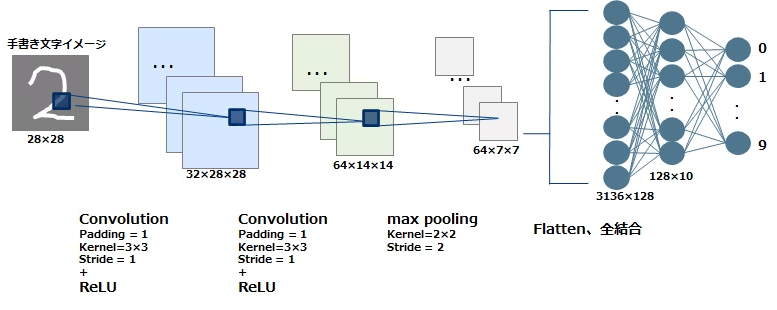

出典: [NPO法人AI開発推進協会](https://sites.google.com/deepaelurus.com/aboutus/home)

### 1. 畳み込み層 (Conv2D)

```python
Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3))
```

- **フィルター数 (32)**: 32個の異なるパターンを検出するフィルターを学習します。初期層では単純なエッジや色の変化を、深い層ではより複雑な形状やパターンを検出します。

- **カーネルサイズ (3, 3)**: 3×3ピクセルの小さな領域を一度に見る「窓」のサイズです。小さいカーネルほど細かい特徴を捉えられますが、計算コストが高くなります。

- **パディング ('same')**: 入力画像の周りに0を追加して、出力の空間的次元が入力と同じになるようにします。'same'を使うと、エッジ情報が保持され、特徴マップのサイズが維持されます。

- **活性化関数 ('relu')**: Rectified Linear Unit。負の値を0にし、正の値はそのまま通します。非線形性を導入して複雑なパターンを学習可能にし、勾配消失問題も軽減します。

- **畳み込み処理の流れ**: フィルターが画像全体を少しずつスライドしながら走査し、入力の局所領域との内積を計算します。この結果が特徴マップとなります。

### 2. プーリング層 (MaxPooling2D)

```python
MaxPooling2D(pool_size=(2, 2))
```

- **目的**: 特徴マップの空間的次元を縮小し、計算量を削減しながら重要な情報を保持します。

- **動作原理**: 2×2の領域内の最大値のみを取り、出力サイズを半分に縮小します。これにより：
  1. パラメータ数と計算量を減らす
  2. 特徴の位置に対する小さな変動に対して頑健になる（位置不変性）
  3. 過学習を抑制する

### 3. ドロップアウト層 (Dropout)

```python
Dropout(0.25)
```

- **動作原理**: 訓練時にランダムに選ばれたニューロンを一時的に「無効化」します。この例では、25%のニューロンが各訓練ステップでランダムに無視されます。

- **目的**: モデルが特定の特徴に過度に依存することを防ぎ、より汎用的な特徴を学習することを促します。これは正則化テクニックの一つであり、過学習を防ぐのに効果的です。

### 4. 平坦化層 (Flatten)

```python
Flatten()
```

- **目的**: 3D特徴マップ（高さ×幅×チャネル）を1Dベクトルに変換し、全結合層への入力として使えるようにします。
- **空間情報**: この変換により空間的な配置情報は失われますが、それまでの畳み込み層とプーリング層で抽出された特徴は保持されます。

### 5. 全結合層 (Dense)

```python
Dense(512, activation='relu')
```

- **ニューロン数 (512)**: 512個のニューロンを持ち、前層からの全ての入力と接続します。
- **目的**: 畳み込み層で抽出された特徴を組み合わせ、高レベルの抽象化を行います。

### 6. 出力層

```python
Dense(10, activation='softmax')
```

- **ニューロン数 (10)**: CIFAR-10の10クラスに対応する10個のニューロン。
- **ソフトマックス活性化**: 出力を確率分布に変換し、各クラスに属する確率を表します。すべての出力の合計は1になります。

### CNNの情報処理の流れ

1. 画像が入力されると、最初の畳み込み層は基本的な特徴（エッジ、テクスチャ、色の変化など）を検出
2. プーリング層で特徴マップの次元を縮小し、重要な特徴を保持
3. 次の畳み込み層でより高度な特徴（形状、パターンなど）を検出
4. さらにプーリングで次元を縮小
5. 平坦化で3D特徴マップを1Dベクトルに変換
6. 全結合層で抽出された特徴を組み合わせて高レベルの抽象化を行う
7. 最終的な出力層で10クラスのいずれかに分類

このように、CNNは画像から徐々に複雑さを増す特徴抽出の階層構造を持っており、初期層から後期層に向かうにつれて抽象度の高い特徴を捉えていきます。

## CNNアーキテクチャの理解

CNNモデルのアーキテクチャを詳しく見ていきましょう：

1. **入力層**：32x32のRGB画像（3チャネル）を受け取ります

2. **第1畳み込みブロック**：
   - 3x3サイズの32フィルターを持つ2つの畳み込み層（ReLU活性化関数使用）
   - 空間的次元を半分に減らすMaxPooling層
   - 過学習を防ぐためのDropout層（25%）

3. **第2畳み込みブロック**：
   - 3x3サイズの64フィルターを持つ2つの畳み込み層（ReLU活性化関数使用）
   - さらに空間的次元を減らすMaxPooling層
   - Dropout層（25%）

4. **全結合層**：
   - 3次元特徴マップを1次元特徴ベクトルに変換するFlatten層
   - 512ニューロンとReLU活性化関数を持つDense層
   - Dropout層（50%）
   - 10ニューロン（クラスごとに1つ）とソフトマックス活性化関数を持つ出力層

このアーキテクチャは一般的なCNN設計パターンに従っています：
- 徐々に複雑な特徴を抽出するための複数の畳み込み層
- 次元と計算の複雑さを削減するためのプーリング層
- 過学習を防ぐための正則化としてのDropout

## CNNモデルの学習

ここで、訓練データを使用してCNNモデルをコンパイルし学習させます。次のものを使用します：
- Adamオプティマイザ：適応的な学習率最適化アルゴリズム
- カテゴリカルクロスエントロピー損失：多クラス分類に適した損失関数
- 精度を評価指標として使用

### データ拡張の重要性

**データ拡張（Data Augmentation）** は、モデルの汎化性能を向上させるための重要なテクニックです。限られたトレーニングデータからモデルがより多様なパターンを学習できるようにします。

#### データ拡張の利点

1. **過学習の軽減**: 同じ画像を様々な変形で見せることで、モデルはデータの本質的な特徴に集中し、訓練データの細かな特徴に過度に適応することを防ぎます。

2. **データセットサイズの実質的増加**: 物理的なデータ量は変わりませんが、モデルにとっては新しいデータを見ているのと同じ効果があります。

3. **位置不変性の強化**: 回転、移動、反転などの変換に対して頑健なモデルが学習されます。

#### 今回使用するデータ拡張

- **回転 (`rotation_range=15`)**: 画像を±15度の範囲でランダムに回転
- **水平移動 (`width_shift_range=0.1`)**: 画像を幅の10%の範囲でランダムに左右に移動
- **垂直移動 (`height_shift_range=0.1`)**: 画像を高さの10%の範囲でランダムに上下に移動
- **水平反転 (`horizontal_flip=True`)**: 画像を左右反転（現実世界の多くの物体は左右反転しても同じクラスに属するため有効）

これらの変換により、各エポックでモデルが見るトレーニングデータは毎回少しずつ異なります。これにより、モデルは画像の本質的な特徴に集中し、よりロバストな学習が可能になります。

In [ ]:
# モデルをコンパイル
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 過学習を防ぐためのデータ拡張を設定
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# データ拡張を使用してモデルを学習
epochs = 5
batch_size = 64

history = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test_one_hot),
    verbose=1
)

### モデルのコンパイルと学習パラメータ

#### オプティマイザ（Optimizer）

- **Adam**: Adaptive Moment Estimationの略で、各パラメータに対して異なる学習率を自動調整します。
  - **動作原理**: 勾配の1次モーメント（平均）と2次モーメント（分散）を利用して学習率を適応的に調整します。
  - **利点**: 初期学習率にあまり敏感ではなく、勾配の鞍点や局所的最適解から抜け出しやすい性質があります。
  - **学習率 (0.001)**: 大きすぎると収束しない、小さすぎると学習が遅くなるため、一般的に良いバランスとされる値を使用しています。

#### 損失関数（Loss Function）

- **カテゴリカルクロスエントロピー**: 多クラス分類タスクで標準的に使用される損失関数です。
  - **数学的意味**: 予測確率分布と実際の分布（One-hotエンコード）の間の情報量の差を測定します。
  - **数式**: $ -\sum_{i=1}^{C} y_i \log(\hat{y}_i) $ （Cはクラス数、yは実際のクラス、ŷは予測確率）
  - **最適値**: 値が小さいほど、モデルの予測がより正確であることを示します。

#### バッチサイズとエポック

- **バッチサイズ (64)**: 一度に処理する画像の数です。
  - **大きいバッチサイズ**: 計算効率が良い、勾配の推定が安定する、より多くのGPUメモリが必要
  - **小さいバッチサイズ**: ノイズの多い勾配だがそれが正則化効果を持つ場合もある、メモリ効率が良い

- **エポック数 (25)**: 全トレーニングデータを何周学習するかを指定します。
  - **少なすぎると**: モデルが十分に学習できない（過少学習）
  - **多すぎると**: 過学習のリスクが高まる、計算コストが増加

#### 検証データ

学習中、各エポック終了時に検証データ（テストデータ）でモデルを評価します。これにより：
- 過学習の早期検出が可能になる
- モデルの汎化性能を確認できる
- ハイパーパラメータの調整の指針となる

検証データは学習に使用せず、モデルの性能評価のみに使用されることに注意が必要です。

## モデルの評価

CNNの学習が完了したので、テストデータセットでその性能を評価してみましょう。

In [ ]:
# テストデータでモデルを評価
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot, verbose=2)
print(f"\nテスト精度: {test_acc:.4f}")
print(f"テスト損失: {test_loss:.4f}")

# 予測を実行
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.squeeze(y_test)

# 分類レポート
print("\n分類レポート:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 混同行列
conf_matrix = confusion_matrix(y_true, y_pred_classes)

In [ ]:
# 混同行列をプロット
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('混同行列')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# テキスト注釈を追加
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('正解ラベル')
plt.xlabel('予測ラベル')
plt.show()

## モデルのパフォーマンス可視化

ここでは、エポックごとの訓練および検証の精度と損失をグラフ化して、モデルの学習性能を分析します。

In [ ]:
# 訓練と検証の精度・損失をプロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 精度
ax1.plot(history.history['accuracy'], label='訓練精度')
ax1.plot(history.history['val_accuracy'], label='検証精度')
ax1.set_title('モデルの精度')
ax1.set_xlabel('エポック')
ax1.set_ylabel('精度')
ax1.legend()

# 損失
ax2.plot(history.history['loss'], label='訓練損失')
ax2.plot(history.history['val_loss'], label='検証損失')
ax2.set_title('モデルの損失')
ax2.set_xlabel('エポック')
ax2.set_ylabel('損失')
ax2.legend()

plt.tight_layout()
plt.show()

# モデルが過学習か、過少学習か、適切な学習かを分析
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
acc_diff = train_acc - val_acc

if acc_diff > 0.1:
    print("モデルが過学習の可能性あり - 訓練精度が検証精度より著しく高い")
elif train_acc < 0.7:
    print("モデルが過少学習の可能性あり - 訓練精度と検証精度が共に低い")
else:
    print("モデルは適切に学習できているようです")

## モデルでの予測

ここでは、学習済みモデルを使用していくつかのテスト画像に対して予測を行い、結果を可視化します。

In [ ]:
# テスト画像のサブセットで予測を実行
num_images = 15
sample_indices = np.random.randint(0, len(x_test), num_images)
sample_images = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# 予測を取得
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.squeeze(sample_labels)

# 予測結果と一緒に画像をプロット
plt.figure(figsize=(15, 12))
for i in range(num_images):
    plt.subplot(3, 5, i + 1)
    plt.imshow(sample_images[i])
    
    color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
    title = f"予測: {class_names[predicted_classes[i]]}\n正解: {class_names[true_classes[i]]}"
    
    plt.title(title, color=color)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## CNN活性化の可視化

畳み込み層の活性化（特徴マップ）を観察することで、CNNがどのような特徴を検出しているのかを可視化してみましょう。

In [ ]:
from tensorflow.keras.models import Model

# First, select a sample image to visualize
img_index = 12
img = x_test[img_index:img_index+1]

# Get all convolutional layers
conv_layers = [layer for layer in model.layers if 'conv' in layer.name.lower()]

# Create separate visualization models for each convolutional layer
layer_activations = []
for layer in conv_layers:
    # Create a new model that returns just this layer's output
    temp_model = Model(inputs=model.inputs, outputs=layer.output)
    # Get activations for our sample image
    activations = temp_model.predict(img)
    layer_activations.append(activations)

# 特定の層の活性化を表示する関数
def display_activations(activations, layer_name, num_channels=16):
    num_to_display = min(num_channels, activations.shape[-1])
    display_grid = np.zeros((activations.shape[1], activations.shape[2] * num_to_display))
    
    for i in range(num_to_display):
        # 各チャネルの活性化を取得
        x = activations[0, :, :, i]
        
        # 可視化のために活性化を0から255の範囲にスケーリング
        x -= x.mean()
        x /= x.std() + 1e-5
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        
        # チャネルをグリッドに追加
        display_grid[:, i * activations.shape[2]:(i + 1) * activations.shape[2]] = x
    
    # グリッドをプロット
    scale = 0.5
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.title(f"{layer_name}の特徴マップ")
    plt.show()

# まず元の画像を表示
plt.figure(figsize=(5, 5))
plt.imshow(x_test[img_index])
plt.title(f"元の画像 - クラス: {class_names[y_test[img_index][0]]}")
plt.axis('off')
plt.show()

# 各畳み込み層の活性化を表示
for i, activations in enumerate(layer_activations):
    display_activations(activations, f"畳み込み層 {i+1}")

## 結論

このノートブックでは、畳み込みニューラルネットワーク（CNN）について次のことを学びました：

1. CIFAR-10データセットのロードと前処理
2. 畳み込み層、プーリング層、全結合層を含むCNNアーキテクチャの構築
3. 過学習を防ぐためのデータ拡張を用いたモデルの学習
4. さまざまな指標を使用したモデルの性能評価
5. モデルの学習進捗とその予測の可視化
6. CNNが生成する特徴マップの探索

CNNが画像分類タスクに強力な理由は以下の通りです：
- 階層的特徴を自動的に学習する
- 局所的な接続性により空間的な局所性を活用する
- 画像全体でパラメータを共有する
- プーリング操作により平行移動に不変である

このモデルをさらに改善するには、以下の方法が考えられます：
- 事前学習済みモデル（ResNet、VGGなど）を用いた転移学習の活用
- より高度な正則化テクニックの適用
- 異なるアーキテクチャとハイパーパラメータの実験
- 収束性を向上させるための学習率スケジューラの使用